# Initialisation GasConsumption and VWAP

In [1460]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import seaborn as sns
from scipy.stats import norm

path='Hedging/HedgeQuarter.xlsx'
xls=pd.ExcelFile(path)
Forward=pd.read_excel(xls,'ForwardPriceMonthly') #Par Mois laisse en mois
VWAP_customers=pd.read_excel(xls,'VWAPCustomers') #Par mois laisse en mois
Consumption_gas=pd.read_excel(xls,'ComsumptionGas2018-2019') #Par Heure passe par mois
#On vas tout convertir par mois car plus simple, pour les heures->jour->mois


#On commence par convertir
def Convert_hourtomonthcons(Consumption_gas):    
    s=0
    Conso_gasmois=[]
    for i in range(len(Consumption_gas)-1):
        s=s+Consumption_gas['Gas'][i]
        if Consumption_gas['Date'][i+1].month!=Consumption_gas['Date'][i].month:
            Conso_gasmois.append(s)
            s=0
    return Conso_gasmois

def Convert_hourtodaycons(Consumption_gas):    
    s=0
    Conso_gasday=[]
    for i in range(len(Consumption_gas)-1):
        s=s+Consumption_gas['Gas'][i]
        if Consumption_gas['Date'][i+1].day!=Consumption_gas['Date'][i].day:
            Conso_gasday.append(s)
            s=0
    return Conso_gasday

ConsomationGasMonth=Convert_hourtomonthcons(Consumption_gas) #Conversion d'heure a mois

Consumption_gas=pd.DataFrame(ConsomationGasMonth,index=pd.date_range(start = pd.to_datetime('2018-01'),
                             periods = len(ConsomationGasMonth), freq='M'), columns = ['Conso Gas']) # consommation de gas KWH
VWAP_customers=pd.DataFrame(VWAP_customers['VWAP_customers'].values,index=pd.date_range(start = pd.to_datetime('2018-01'),
                             periods = len(VWAP_customers), freq='M'), columns = ['VWAP_customers'])

# Iniatialisation of gas price over 2016

In [1461]:
dataforward=pd.ExcelFile('ForwardPrice2016.xlsx')
gas=pd.read_excel(dataforward,'Gas')
gas.keys()
gas=gas.drop('Delivery\Today',1)


In [1462]:

gas=pd.DataFrame(gas.values,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys())

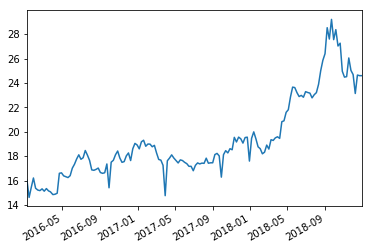

In [1463]:
day=pd.to_datetime('2018-01-31')
gas.loc[pd.to_datetime('2019-01-31')].plot()

## Creation of a Dataframe which do a synthesis of all the Data per month

In [1464]:
synthese=VWAP_customers.merge(Consumption_gas,right_index=True,left_index=True)

# Choose of Today Date, for the Forward Price

In [1465]:
Today=pd.to_datetime('23-09-2016')
synthese=synthese.merge(gas[Today],right_index=True,left_index=True)
synthese=synthese.rename(columns={Today:'Today'})


# Function calculating the moving Average

In [1466]:
def calcul_MM(gas,nbr_week): #MM
    Total=[]
    for i in gas.index:
        mois=[]
        for j in gas.keys():
            s=np.mean(gas.loc[i,j-timedelta(days=nbr_week*7):j])
            mois.append(s)
        Total.append(mois)
    return Total
TotalMM20=calcul_MM(gas,2)
TotalMM50=calcul_MM(gas,9)
MM20=pd.DataFrame(TotalMM20,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys()) #CalculMM20
MM50=pd.DataFrame(TotalMM50,index=pd.date_range(start = pd.to_datetime('2017-01-01'),
                             periods = len(gas), freq='M'),columns=gas.keys()) #CalculMM20

# Vision of the moving average 20 Days, it smooth the curve

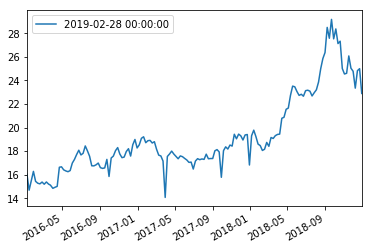

In [1467]:
gas.loc[pd.to_datetime('2019-02-28')].plot()
plt.legend()

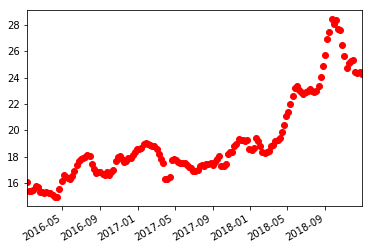

In [1468]:
MM20.loc[pd.to_datetime('2019-02-28')].plot(style='ro')
#MM50.loc[pd.to_datetime('2019-02-28')].plot(style='o')

# Adding the Moving average to the synthesis

In [1469]:
synthese=synthese.merge(MM20[Today],left_index=True,right_index=True)

# Defining the Date of the previous Week, and put the moving average in the synthesis

In [1470]:
LastWeek=Today-timedelta(days=7)

In [1471]:
synthese=synthese.merge(MM20[LastWeek],left_index=True,right_index=True)

# Function which gives the signal to Hedge !!!

In [1472]:
def Signal(MarketPrice,VWAP,TodayMM20,LastWeekMM20):
    Etat=[]
    for i in range(len(VWAP)):
        if MarketPrice[i]>=VWAP[i]+0.5 and TodayMM20[i]>LastWeekMM20[i]+0.4: #the market price above 1 euros avec the mm superiour than last week by 0,15 cents15
            Etat.append('Long')
        elif MarketPrice[i]>=VWAP[i]+0.5 and TodayMM20[i]<LastWeekMM20[i]-0.40:
            Etat.append('Short')

        elif MarketPrice[i]<VWAP[i]-0.5 and TodayMM20[i]>LastWeekMM20[i]+0.40:
            Etat.append('Long')

        elif MarketPrice[i]<VWAP[i]-0.5 and TodayMM20[i]<LastWeekMM20[i]-0.40:
            Etat.append('Short')
        elif MarketPrice[i]>=VWAP[i]-0.5 and MarketPrice[i]<=VWAP[i]+0.5 and abs(MarketPrice[i]-VWAP[i])>0.2:
             Etat.append('Inbox')
        else :
            Etat.append('Flat')
            
    return Etat




# Putting the state in the synthesis

In [1473]:
synthese['Etat']=Signal(synthese['Today'],synthese['VWAP_customers'],synthese[Today],synthese[LastWeek])

# put the gas consumption in MWH

In [1474]:
synthese['Conso Gas']=synthese['Conso Gas']/1000

# Putting the previous hedge to 0

In [1475]:
synthese['PreviousHedge']=0.

# Function for the hedging strategy 

In [1476]:
def Volatility(today,Tdelivery): #en jour
    if ((Tdelivery-today).days/90)<(30/90):
        return (1/5)*(30/90)**(-2/5)
    else:
        return (1/5)*((Tdelivery-today).days/90)**(-2/5)

def delta_vol(ForwardPrice,VWAP,upperPrice):
    Delta=ForwardPrice-VWAP
    if Delta>=upperPrice:
        return 1
    if Delta <=-upperPrice:
        return 0
    else:
        return norm.cdf(Delta,0,upperPrice/3)


def calcul_volume_normal(ForwardPrice,VWAP,upperPrice,BoundVol,VolumeBase,previous_hedge):
    delta=delta_vol(ForwardPrice,VWAP,upperPrice)-0.50
    volume=(BoundVol/0.5)*delta*VolumeBase - previous_hedge
    return volume
    
def coef_aggresivity(volatility,cst_aggresivity): #calcul du coefficient d'agressivity
    return 1.6 -(volatility)-cst_aggresivity


def calcul_upperPrice(today,Tdelivery):  #upperPriceBase,volatility,cst_aggresivity):
    #return upperPriceBase*coef_aggresivity(volatility,cst_aggresivity) #Calcul de l'upperprice
    if ((Tdelivery-today).days)<15:
         return  9.7308*np.log(15)-18.079  #0.023*(15)-3.59 #(1.67)*np.exp((3/4)*30) #9.7308*np.log(15)-22.079 
    else:
         return  9.7308*np.log((Tdelivery-today).days)-18.079  #0.023*((Tdelivery-today).days)-3.59 #9.7308*np.log((Tdelivery-today).days)-23.079 #5.9*((Tdelivery-today).days/30)-3.5 #(1.67)*np.exp((3/4)*(Tdelivery-today).days)

def calcul_volume(BoundPrice,ForwardPrice,VWAP,upperPrice,VolumeBase,previous_hedge,form): #Calcul du volume
        Delta=ForwardPrice-VWAP
        if Delta>upperPrice:
            Delta=upperPrice
        if Delta<-upperPrice:
            Delta=-upperPrice
        if Delta>0:
            if form=='linear':
                return (((BoundPrice/upperPrice)*VolumeBase)*Delta) - previous_hedge #lineaire # Bound price : 0.20 percent
            if form=='quadratic':
                return ((BoundPrice/upperPrice**2)*VolumeBase)*Delta**2 - previous_hedge
            if form=='squared':
                return ((BoundPrice/np.sqrt(upperPrice))*VolumeBase)*np.sqrt(Delta) - previous_hedge
            
        if Delta<0:
            if form=='linear':
                return (((BoundPrice/upperPrice)*VolumeBase)*Delta) - previous_hedge #lineaire # Bound price : 0.20 percent
            if form=='quadratic':
                return -((BoundPrice/upperPrice**2)*VolumeBase)*Delta**2 - previous_hedge
            if form=='squared':
                return -((BoundPrice/np.sqrt(upperPrice))*VolumeBase)*np.sqrt(-Delta) - previous_hedge 



    
def Hedging2(ForwardPrice,VWAP,Volume,Today,Etat,upperPriceBase,cst_agressivity,previousHedge,BoundPrice,form):
    Volume=-Volume
    VolumeHedged=[]
    ValueHedged=[]
    cost_transac=[]
    print(' Hedging Strategy for '+str(Today.day)+'-'+str(Today.month)+'-'+str(Today.year)+' :')
    
    for i in range(len(ForwardPrice)):
        if Etat[i]=='Short':
                #volatility=Volatility(Today,Etat.index[i])
                upperPrice=calcul_upperPrice(Today,Etat.index[i]) #upperPriceBase,volatility,cst_agressivity)
                new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form)   #calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form)
                costtrans=0.1*abs(new_volume)
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                else:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        elif Etat[i]=='Long':
                #volatility=Volatility(Today,Etat.index[i])
                upperPrice=calcul_upperPrice( Today,Etat.index[i]) #upperPriceBase,volatility,cst_agressivity)
                new_volume=calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form) #calcul_volume(BoundPrice,ForwardPrice[i],VWAP[i],upperPrice,Volume[i],previousHedge[i],form)
                costtrans=0.1*abs(new_volume) #long
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                else:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))   
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        elif Etat[i]=='Inbox':
                new_volume=-previousHedge[i]
                costtrans=0.1*abs(new_volume) #flt
                ValueSell=-(new_volume*ForwardPrice[i]) #- costtrans
                if new_volume<0:
                    print('For Delivery in %d-%d ,Sold %f MWH,and we receive is %f Euros (100)' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))
                if new_volume>0:
                    print('For Delivery in %d-%d ,Buy %f MWH,and we pay is %f Euros 100' % (Etat.index[i].year,Etat.index[i].month,new_volume,ValueSell))  
                VolumeHedged.append(new_volume)
                ValueHedged.append(ValueSell)
                cost_transac.append(costtrans)
        else:
                VolumeHedged.append(0)
                ValueHedged.append(0)
                cost_transac.append(0)
    return (VolumeHedged,ValueHedged,cost_transac)
    


In [1477]:
ojd=pd.to_datetime('30-09-2016')
deliv=pd.to_datetime('30-09-2021')

Volatility(ojd,deliv)

0.05999660697570666

In [1478]:
cst_agressivity=0. #constante empirique
upperPriceBase=4 #Calcul grace a la variation standart

Hedg=Hedging2(synthese['Today'],synthese['VWAP_customers'],synthese['Conso Gas'],Today,synthese['Etat'],upperPriceBase,cst_agressivity,synthese['PreviousHedge'],0.2,'linear')

 Hedging Strategy for 23-9-2016 :


# Vue of synthese

In [1479]:
synthese

,VWAP_customers,Conso Gas,Today,2016-09-23 00:00:00,2016-09-16 00:00:00,Etat,PreviousHedge
2018-01-31,17.791018,-2313.432807,17.074686,16.569187,16.376859,Flat,0.0
2018-02-28,17.792241,-2043.327181,17.007285,16.505285,16.312524,Flat,0.0
2018-03-31,17.762505,-1877.761861,16.570338,16.068934,15.869239,Flat,0.0
2018-04-30,17.691166,-1341.883546,15.878688,15.375273,15.163764,Flat,0.0
2018-05-31,17.626902,-908.000000,15.406689,14.899984,14.680117,Flat,0.0
2018-06-30,17.832523,-891.000000,15.278502,14.767605,14.544910,Flat,0.0
2018-07-31,17.924734,-895.000000,15.438503,14.923564,14.702399,Flat,0.0
2018-08-31,17.935999,-906.000000,15.693948,15.179263,14.959195,Flat,0.0
2018-09-30,17.972764,-1067.000000,15.979475,15.470326,15.249733,Flat,0.0
2018-10-31,18.123518,-1965.000000,16.323514,15.823461,15.600857,Flat,0.0


# SIMULATION

In [1501]:
synthese['PreviousHedge']=0.
synthese['Valueofhedge']=0.
synthese['Cost of transaction']=0.
cst_agressivity=0. #constante empirique
upperPriceBase=4 #Calcul grace a la variation standart
if Today in synthese.columns:
    synthese= synthese.drop([Today],axis=1)
if LastWeek in synthese.columns:
    synthese= synthese.drop([LastWeek],axis=1)
#del synthese[LastWeek]
for date in gas.keys()[20:]:
    Today=date
    LastWeek=Today-timedelta(days=21)
    #ForwardPrice
    synthese= synthese.drop(['Today'],axis=1)
    synthese=synthese.merge(gas[Today],right_index=True,left_index=True)
    synthese=synthese.rename(columns={Today:'Today'})
    #MM20
    synthese=synthese.merge(MM20[Today],left_index=True,right_index=True)
    synthese=synthese.merge(MM20[LastWeek],left_index=True,right_index=True)
    synthese['Etat']=Signal(synthese['Today'],synthese['VWAP_customers'],synthese[Today],synthese[LastWeek])
    Hedgi=Hedging2(synthese['Today'],synthese['VWAP_customers'],synthese['Conso Gas'],Today,synthese['Etat'],upperPriceBase,cst_agressivity,synthese['PreviousHedge'],0.2,'squared')
    synthese['PreviousHedge']=synthese['PreviousHedge']+Hedgi[0]
    synthese['Valueofhedge']=synthese['Valueofhedge']+Hedgi[1]
    synthese['Cost of transaction']=synthese['Cost of transaction']+Hedgi[2]
    synthese= synthese.drop([Today,LastWeek],axis=1)

 Hedging Strategy for 27-5-2016 :
For Delivery in 2020-2 ,Sold -2180.683657 MWH,and we receive is 35458.986067 Euros
For Delivery in 2020-3 ,Sold -1954.547420 MWH,and we receive is 31033.474414 Euros
For Delivery in 2020-12 ,Sold -2293.668999 MWH,and we receive is 36624.532286 Euros
For Delivery in 2021-1 ,Sold -2104.548206 MWH,and we receive is 34364.517961 Euros
For Delivery in 2021-2 ,Sold -1768.259034 MWH,and we receive is 28982.078160 Euros
For Delivery in 2021-3 ,Sold -1599.085239 MWH,and we receive is 25662.417253 Euros
For Delivery in 2021-4 ,Sold -1101.225796 MWH,and we receive is 16953.680710 Euros
For Delivery in 2021-5 ,Sold -610.956852 MWH,and we receive is 9137.503668 Euros
For Delivery in 2021-6 ,Sold -375.308576 MWH,and we receive is 5583.251290 Euros
For Delivery in 2021-7 ,Sold -320.746445 MWH,and we receive is 4827.261829 Euros
For Delivery in 2021-8 ,Sold -317.270671 MWH,and we receive is 4842.062736 Euros
For Delivery in 2021-9 ,Sold -442.279639 MWH,and we receive 

 Hedging Strategy for 15-7-2016 :
For Delivery in 2018-2 ,Buy 44.593296 MWH,and we pay is -808.801900 Euros 100
 Hedging Strategy for 22-7-2016 :
 Hedging Strategy for 29-7-2016 :
 Hedging Strategy for 5-8-2016 :
For Delivery in 2018-3 ,Sold -68.227968 MWH,and we receive is 1112.328494 Euros
For Delivery in 2018-4 ,Sold -16.591798 MWH,and we receive is 258.328481 Euros
For Delivery in 2018-5 ,Sold -10.042700 MWH,and we receive is 151.282682 Euros
For Delivery in 2018-6 ,Sold -9.307055 MWH,and we receive is 138.828125 Euros
For Delivery in 2018-7 ,Sold -9.679534 MWH,and we receive is 145.898092 Euros
For Delivery in 2018-8 ,Sold -10.152624 MWH,and we receive is 155.794710 Euros
For Delivery in 2018-9 ,Sold -11.837777 MWH,and we receive is 185.484962 Euros
For Delivery in 2018-10 ,Sold -20.519532 MWH,and we receive is 329.477841 Euros
For Delivery in 2018-12 ,Sold -44.739909 MWH,and we receive is 745.679839 Euros
For Delivery in 2019-1 ,Sold -307.931255 MWH,and we receive is 5198.449087 

 Hedging Strategy for 9-9-2016 :
 Hedging Strategy for 16-9-2016 :
For Delivery in 2018-1 ,Sold -20.022658 MWH,and we receive is 327.116120 Euros
For Delivery in 2018-2 ,Sold -16.913411 MWH,and we receive is 275.262148 Euros
For Delivery in 2018-3 ,Sold -12.742951 MWH,and we receive is 201.901563 Euros
For Delivery in 2018-4 ,Sold -7.153525 MWH,and we receive is 108.443103 Euros
For Delivery in 2018-5 ,Sold -4.258589 MWH,and we receive is 62.557816 Euros
For Delivery in 2018-6 ,Sold -3.990764 MWH,and we receive is 58.099027 Euros
For Delivery in 2018-7 ,Sold -4.225300 MWH,and we receive is 62.160568 Euros
For Delivery in 2018-8 ,Sold -4.386905 MWH,and we receive is 65.648248 Euros
For Delivery in 2018-9 ,Sold -4.900773 MWH,and we receive is 74.757715 Euros
For Delivery in 2018-10 ,Sold -1.059374 MWH,and we receive is 16.533433 Euros
 Hedging Strategy for 23-9-2016 :
 Hedging Strategy for 30-9-2016 :
For Delivery in 2018-5 ,Buy 19.961425 MWH,and we pay is -332.767422 Euros
For Delivery 

 Hedging Strategy for 18-11-2016 :
For Delivery in 2018-11 ,Sold -17.557019 MWH,and we receive is 295.563793 Euros
For Delivery in 2018-12 ,Sold -21.583798 MWH,and we receive is 371.619154 Euros
For Delivery in 2019-1 ,Sold -100.234428 MWH,and we receive is 1759.964885 Euros
For Delivery in 2019-2 ,Sold -76.791780 MWH,and we receive is 1344.167647 Euros
 Hedging Strategy for 25-11-2016 :
For Delivery in 2018-6 ,Buy 3.039750 MWH,and we pay is -48.605756 Euros
For Delivery in 2018-9 ,Sold -0.350887 MWH,and we receive is 5.736498 Euros
For Delivery in 2018-10 ,Sold -0.889446 MWH,and we receive is 14.954795 Euros
For Delivery in 2018-11 ,Buy 17.305730 MWH,and we pay is -298.841353 Euros
For Delivery in 2018-12 ,Buy 25.688950 MWH,and we pay is -454.002306 Euros
For Delivery in 2019-1 ,Buy 154.023610 MWH,and we pay is -2776.735065 Euros
 Hedging Strategy for 2-12-2016 :
 Hedging Strategy for 9-12-2016 :
 Hedging Strategy for 16-12-2016 :
For Delivery in 2018-4 ,Buy 37.200429 MWH,and we pay i

 Hedging Strategy for 24-2-2017 :
 Hedging Strategy for 3-3-2017 :
For Delivery in 2018-1 ,Sold -97.449130 MWH,and we receive is 1768.938453 Euros (100)
For Delivery in 2018-2 ,Sold -82.380664 MWH,and we receive is 1491.481887 Euros (100)
For Delivery in 2018-4 ,Sold -34.278745 MWH,and we receive is 583.633242 Euros
For Delivery in 2018-5 ,Sold -30.286989 MWH,and we receive is 498.942638 Euros
 Hedging Strategy for 10-3-2017 :
For Delivery in 2018-3 ,Sold -108.783338 MWH,and we receive is 1867.024084 Euros
For Delivery in 2018-4 ,Sold -11.408944 MWH,and we receive is 188.412122 Euros
For Delivery in 2018-5 ,Sold -5.919708 MWH,and we receive is 94.626791 Euros
For Delivery in 2018-6 ,Sold -40.401176 MWH,and we receive is 633.368122 Euros
For Delivery in 2018-7 ,Sold -16.739590 MWH,and we receive is 260.807578 Euros
For Delivery in 2018-8 ,Sold -17.140346 MWH,and we receive is 268.817772 Euros
For Delivery in 2018-9 ,Sold -16.670685 MWH,and we receive is 266.226368 Euros
For Delivery in 

 Hedging Strategy for 21-4-2017 :
For Delivery in 2018-4 ,Buy 7.346489 MWH,and we pay is -124.194476 Euros
For Delivery in 2018-12 ,Buy 29.137287 MWH,and we pay is -517.581817 Euros
For Delivery in 2019-1 ,Buy 91.216555 MWH,and we pay is -1652.148690 Euros
For Delivery in 2019-2 ,Buy 74.221658 MWH,and we pay is -1336.734844 Euros
For Delivery in 2019-3 ,Buy 51.002851 MWH,and we pay is -887.503682 Euros
For Delivery in 2019-6 ,Buy 8.608580 MWH,and we pay is -134.577751 Euros
For Delivery in 2019-12 ,Buy 105.624472 MWH,and we pay is -1831.212299 Euros
For Delivery in 2020-1 ,Buy 89.755803 MWH,and we pay is -1597.438450 Euros
For Delivery in 2020-2 ,Buy 70.375926 MWH,and we pay is -1252.227741 Euros
For Delivery in 2020-3 ,Buy 43.070720 MWH,and we pay is -743.015605 Euros
For Delivery in 2020-6 ,Buy 3.430506 MWH,and we pay is -53.224128 Euros
 Hedging Strategy for 28-4-2017 :
For Delivery in 2018-4 ,Sold -6.147481 MWH,and we receive is 102.257121 Euros
For Delivery in 2018-12 ,Sold -18.10

 Hedging Strategy for 23-6-2017 :
For Delivery in 2018-1 ,Sold -2.182348 MWH,and we receive is 36.094610 Euros
For Delivery in 2018-2 ,Sold -28.580852 MWH,and we receive is 471.761882 Euros
For Delivery in 2018-3 ,Sold -20.884849 MWH,and we receive is 338.021856 Euros
For Delivery in 2018-4 ,Sold -12.812371 MWH,and we receive is 200.567340 Euros
For Delivery in 2018-7 ,Sold -8.484493 MWH,and we receive is 125.890879 Euros
For Delivery in 2018-8 ,Sold -8.467181 MWH,and we receive is 126.693074 Euros
For Delivery in 2018-9 ,Sold -6.718581 MWH,and we receive is 102.863604 Euros
 Hedging Strategy for 30-6-2017 :
For Delivery in 2018-1 ,Sold -20.645551 MWH,and we receive is 328.295578 Euros
For Delivery in 2018-2 ,Sold -32.577846 MWH,and we receive is 495.842691 Euros
For Delivery in 2018-3 ,Sold -27.906162 MWH,and we receive is 414.943436 Euros
For Delivery in 2018-4 ,Sold -11.606164 MWH,and we receive is 172.254890 Euros
For Delivery in 2018-5 ,Sold -9.522529 MWH,and we receive is 143.301

 Hedging Strategy for 27-10-2017 :
For Delivery in 2018-4 ,Buy 35.571973 MWH,and we pay is -612.478235 Euros 100
For Delivery in 2018-5 ,Buy 4.732840 MWH,and we pay is -78.566872 Euros
For Delivery in 2018-6 ,Buy 6.191786 MWH,and we pay is -102.805063 Euros
For Delivery in 2018-12 ,Buy 130.903868 MWH,and we pay is -2394.997112 Euros 100
For Delivery in 2019-1 ,Buy 136.758064 MWH,and we pay is -2546.072856 Euros
For Delivery in 2019-2 ,Buy 117.413558 MWH,and we pay is -2174.940567 Euros
For Delivery in 2019-3 ,Buy 93.820413 MWH,and we pay is -1686.698874 Euros
For Delivery in 2019-4 ,Buy 85.762018 MWH,and we pay is -1466.584460 Euros
For Delivery in 2019-11 ,Buy 113.722437 MWH,and we pay is -1980.639550 Euros
For Delivery in 2019-12 ,Buy 158.394347 MWH,and we pay is -2829.801629 Euros
For Delivery in 2020-1 ,Buy 229.449022 MWH,and we pay is -4184.154648 Euros
For Delivery in 2020-2 ,Buy 188.437524 MWH,and we pay is -3416.279410 Euros
For Delivery in 2020-3 ,Buy 140.085893 MWH,and we pay

 Hedging Strategy for 15-12-2017 :
For Delivery in 2018-1 ,Buy 8.711822 MWH,and we pay is -183.261895 Euros
For Delivery in 2018-2 ,Buy 5.348768 MWH,and we pay is -111.981812 Euros
For Delivery in 2018-3 ,Buy 0.597823 MWH,and we pay is -12.176464 Euros
For Delivery in 2020-5 ,Sold -21.878873 MWH,and we receive is 348.360303 Euros
For Delivery in 2020-6 ,Sold -13.587560 MWH,and we receive is 213.732710 Euros
For Delivery in 2020-7 ,Sold -12.467443 MWH,and we receive is 199.396278 Euros
For Delivery in 2020-8 ,Sold -13.213223 MWH,and we receive is 215.607940 Euros
For Delivery in 2020-9 ,Sold -19.580406 MWH,and we receive is 325.607734 Euros
For Delivery in 2020-10 ,Sold -44.316238 MWH,and we receive is 749.691869 Euros
For Delivery in 2020-11 ,Sold -71.109672 MWH,and we receive is 1227.920677 Euros
 Hedging Strategy for 22-12-2017 :
For Delivery in 2018-1 ,Sold -38.842589 MWH,and we receive is 764.228025 Euros
For Delivery in 2018-2 ,Sold -32.073309 MWH,and we receive is 630.080094 Euro

 Hedging Strategy for 30-3-2018 :
For Delivery in 2018-5 ,Buy 29.408974 MWH,and we pay is -535.419805 Euros
For Delivery in 2018-10 ,Buy 65.148566 MWH,and we pay is -1200.230202 Euros 100
For Delivery in 2018-11 ,Buy 74.159148 MWH,and we pay is -1395.206628 Euros
For Delivery in 2018-12 ,Buy 105.560888 MWH,and we pay is -2028.585483 Euros
For Delivery in 2019-1 ,Buy 50.430613 MWH,and we pay is -988.046149 Euros
For Delivery in 2019-2 ,Buy 50.052274 MWH,and we pay is -972.247112 Euros
 Hedging Strategy for 6-4-2018 :
For Delivery in 2018-5 ,Sold -0.443749 MWH,and we receive is 8.058031 Euros
For Delivery in 2018-11 ,Buy 14.410253 MWH,and we pay is -274.349109 Euros
For Delivery in 2018-12 ,Sold -105.560888 MWH,and we receive is 2006.981427 Euros (100)
For Delivery in 2019-1 ,Sold -85.463554 MWH,and we receive is 1663.251502 Euros
For Delivery in 2019-2 ,Buy 11.261486 MWH,and we pay is -219.051866 Euros
For Delivery in 2019-3 ,Buy 68.206402 MWH,and we pay is -1274.254658 Euros
For Delive

For Delivery in 2019-12 ,Buy 709.220376 MWH,and we pay is -15369.875492 Euros
For Delivery in 2020-1 ,Buy 583.575916 MWH,and we pay is -12956.548313 Euros
For Delivery in 2020-2 ,Buy 486.617994 MWH,and we pay is -10688.250262 Euros
For Delivery in 2020-3 ,Buy 1288.029969 MWH,and we pay is -26842.098087 Euros
For Delivery in 2020-4 ,Buy 760.537771 MWH,and we pay is -14507.440081 Euros 100
For Delivery in 2020-5 ,Buy 88.918530 MWH,and we pay is -1589.581723 Euros
For Delivery in 2020-6 ,Buy 51.074633 MWH,and we pay is -897.397126 Euros
For Delivery in 2020-7 ,Buy 53.551542 MWH,and we pay is -961.660208 Euros
For Delivery in 2020-8 ,Buy 64.255662 MWH,and we pay is -1183.108811 Euros
For Delivery in 2020-9 ,Buy 102.719152 MWH,and we pay is -1931.235541 Euros
For Delivery in 2020-10 ,Buy 617.532953 MWH,and we pay is -11806.772364 Euros 100
For Delivery in 2020-12 ,Buy 1384.009154 MWH,and we pay is -27530.705634 Euros 100
For Delivery in 2021-1 ,Buy 1270.318977 MWH,and we pay is -25732.27923

For Delivery in 2022-8 ,Sold -2.920721 MWH,and we receive is 51.651366 Euros
For Delivery in 2022-9 ,Sold -8.966896 MWH,and we receive is 160.621521 Euros
For Delivery in 2022-10 ,Sold -209.992613 MWH,and we receive is 3807.301957 Euros
For Delivery in 2022-11 ,Buy 534.376350 MWH,and we pay is -9788.482995 Euros 100
For Delivery in 2022-12 ,Buy 671.162044 MWH,and we pay is -12356.370978 Euros 100
 Hedging Strategy for 13-7-2018 :
For Delivery in 2018-8 ,Buy 16.425532 MWH,and we pay is -365.632346 Euros
For Delivery in 2018-9 ,Buy 13.850933 MWH,and we pay is -308.875799 Euros
For Delivery in 2018-10 ,Buy 17.692998 MWH,and we pay is -396.677050 Euros
For Delivery in 2018-11 ,Buy 20.685231 MWH,and we pay is -472.657493 Euros
For Delivery in 2018-12 ,Buy 26.013513 MWH,and we pay is -598.831075 Euros
For Delivery in 2019-3 ,Sold -20.123984 MWH,and we receive is 458.899441 Euros
For Delivery in 2019-4 ,Sold -16.134571 MWH,and we receive is 343.410520 Euros
For Delivery in 2019-6 ,Sold -3.170

For Delivery in 2020-10 ,Buy 47.184024 MWH,and we pay is -956.896460 Euros
For Delivery in 2020-11 ,Buy 40.161813 MWH,and we pay is -828.243150 Euros
For Delivery in 2020-12 ,Buy 49.553022 MWH,and we pay is -1045.117306 Euros
For Delivery in 2021-1 ,Buy 65.564322 MWH,and we pay is -1412.746281 Euros
For Delivery in 2021-2 ,Buy 72.493224 MWH,and we pay is -1555.715093 Euros
For Delivery in 2021-3 ,Buy 85.607473 MWH,and we pay is -1770.261402 Euros
For Delivery in 2021-5 ,Buy 31.981139 MWH,and we pay is -590.291681 Euros
For Delivery in 2021-6 ,Buy 16.568042 MWH,and we pay is -301.317862 Euros
For Delivery in 2021-7 ,Buy 15.870158 MWH,and we pay is -292.437432 Euros
For Delivery in 2021-8 ,Buy 131.166474 MWH,and we pay is -2473.864319 Euros 100
For Delivery in 2022-1 ,Buy 42.366407 MWH,and we pay is -852.071550 Euros
For Delivery in 2022-2 ,Buy 23.305256 MWH,and we pay is -460.093784 Euros
For Delivery in 2022-3 ,Buy 465.189536 MWH,and we pay is -8936.521000 Euros
For Delivery in 2022-5 

For Delivery in 2021-10 ,Sold -184.685498 MWH,and we receive is 3903.656071 Euros
For Delivery in 2021-11 ,Sold -287.249170 MWH,and we receive is 6190.347842 Euros
For Delivery in 2021-12 ,Sold -377.375129 MWH,and we receive is 8242.681960 Euros
For Delivery in 2022-1 ,Sold -274.840060 MWH,and we receive is 6037.978381 Euros
For Delivery in 2022-2 ,Sold -244.240299 MWH,and we receive is 5296.465111 Euros
For Delivery in 2022-3 ,Sold -208.584052 MWH,and we receive is 4358.233204 Euros
For Delivery in 2022-4 ,Sold -126.218405 MWH,and we receive is 2489.280847 Euros
For Delivery in 2022-5 ,Sold -147.163513 MWH,and we receive is 2789.516840 Euros (100)
For Delivery in 2022-7 ,Sold -35.940428 MWH,and we receive is 684.116770 Euros (100)
For Delivery in 2022-8 ,Sold -13.440226 MWH,and we receive is 260.592806 Euros
For Delivery in 2022-9 ,Sold -32.150054 MWH,and we receive is 633.598408 Euros
For Delivery in 2022-10 ,Sold -93.438665 MWH,and we receive is 1865.369068 Euros
For Delivery in 202

For Delivery in 2021-7 ,Sold -51.047483 MWH,and we receive is 923.508233 Euros
For Delivery in 2021-8 ,Sold -147.962127 MWH,and we receive is 2738.429481 Euros
For Delivery in 2021-11 ,Sold -260.199334 MWH,and we receive is 5160.980846 Euros
For Delivery in 2021-12 ,Sold -292.535183 MWH,and we receive is 5883.670221 Euros
For Delivery in 2022-1 ,Sold -173.960158 MWH,and we receive is 3520.003967 Euros
For Delivery in 2022-2 ,Sold -161.661702 MWH,and we receive is 3233.274792 Euros
For Delivery in 2022-3 ,Sold -177.699455 MWH,and we receive is 3433.966528 Euros
For Delivery in 2022-5 ,Sold -138.977672 MWH,and we receive is 2454.918266 Euros
For Delivery in 2022-6 ,Sold -15.048002 MWH,and we receive is 263.651944 Euros
For Delivery in 2022-7 ,Sold -30.201750 MWH,and we receive is 536.469810 Euros
For Delivery in 2022-8 ,Sold -54.882411 MWH,and we receive is 991.414955 Euros
 Hedging Strategy for 30-11-2018 :
For Delivery in 2018-12 ,Buy 3.058140 MWH,and we pay is -75.321984 Euros
For Del

# Test

In [1502]:
synthese

,VWAP_customers,Conso Gas,Etat,PreviousHedge,Valueofhedge,Cost of transaction,Today
2018-01-31,17.791018,-2313.432807,Flat,217.854198,-4648.424620,126.018014,19.624998
2018-02-28,17.792241,-2043.327181,Flat,0.000000,-609.430621,137.421516,17.853809
2018-03-31,17.762505,-1877.761861,Flat,224.294986,-5292.597790,160.803187,20.713270
2018-04-30,17.691166,-1341.883546,Flat,56.289897,-1231.751887,71.469594,18.393846
2018-05-31,17.626902,-908.000000,Flat,88.358210,-1862.144047,44.237391,20.247999
2018-06-30,17.832523,-891.000000,Flat,103.945574,-2356.285563,44.381073,21.915276
2018-07-31,17.924734,-895.000000,Flat,75.069443,-1742.578235,45.573731,21.958338
2018-08-31,17.935999,-906.000000,Flat,84.033144,-1975.269916,53.537660,21.890311
2018-09-30,17.972764,-1067.000000,Flat,211.908132,-5411.779604,105.743558,26.129998
2018-10-31,18.123518,-1965.000000,Flat,327.409187,-8365.976384,142.945060,27.579998


# Value given or received

In [1503]:

synthese['PreviousHedge'].sum()

35688.189520170694

In [1504]:
synthese['Valueofhedge'].sum()

-1054850.036797673

In [1505]:
Value_Portfolio=0
for i in range(len(synthese['Valueofhedge'])):
    Value_Portfolio=Value_Portfolio+synthese['VWAP_customers'][i]*(-synthese['Conso Gas'][i])

In [1506]:
Value_Portfolio

20195175.043586142

In [1507]:
100*(synthese['Valueofhedge'].sum()/Value_Portfolio)

-5.2232775131735565

# TEST DU P&L

In [1508]:
PL=pd.DataFrame(index=pd.date_range(start = pd.to_datetime('2018-01-31'),
                             periods = len(synthese), freq='M'))

## Case of volume correlated with price

In [1509]:
PL['VWAP']=synthese['VWAP_customers']
PL['Spot Price']=synthese['Today'] #RANDOM EST FIXE
PL['Expected Conso']=-synthese['Conso Gas'] #consommation en positif
PL['Hedge Volume']=PL['Expected Conso']+synthese['PreviousHedge']
PL['Real Conso']=0.

for i in range(len(PL)):
    if PL['Spot Price'][i]>PL['VWAP'][i]:
        PL['Real Conso'][i]=(1+abs(np.random.normal(1,0.1)-1))*PL['Expected Conso'][i]
    else:
        PL['Real Conso'][i]=(1-abs(np.random.normal(1,0.1)-1))*PL['Expected Conso'][i]
#PL['Real Conso']=PL['Hedge Volume']
PL['Value Hedge']=synthese['Valueofhedge']
PL['Open position Hedge']=(PL['Hedge Volume']-PL['Real Conso'])
PL['Open position Unhedged']=(PL['Expected Conso']-PL['Real Conso'])
PL['PL Hedge']=PL['Real Conso']*PL['VWAP'] + PL['Value Hedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
PL['PL Unhedged']=PL['Real Conso']*PL['VWAP']  - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']

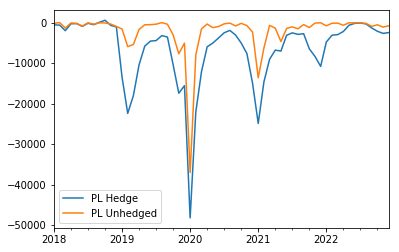

In [1510]:
PL['PL Hedge'].plot()
PL['PL Unhedged'].plot()
plt.legend()


# Simulation of different volume

In [1511]:
simulationhedge=pd.DataFrame(index=PL.index)
simulationunhedge=pd.DataFrame(index=PL.index)
density_hedge=[]
density_unhedge=[]
for i in range(1000):
    for j in range(len(PL)):
        if PL['Spot Price'][j]>PL['VWAP'][j]:
            PL['Real Conso'][j]=np.random.uniform(0.8,1.2)*PL['Expected Conso'][j]
        else:
            PL['Real Conso'][j]=np.random.uniform(0.8,1.2)*PL['Expected Conso'][j]
    simulationhedge['essai n '+str(i)]=PL['Real Conso']*PL['VWAP'] + synthese['Valueofhedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
    density_hedge.append(simulationhedge['essai n '+str(i)].sum())
    simulationunhedge['essai n '+str(i)]=PL['Real Conso']*PL['VWAP']  - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']
    density_unhedge.append(simulationunhedge['essai n '+str(i)].sum())

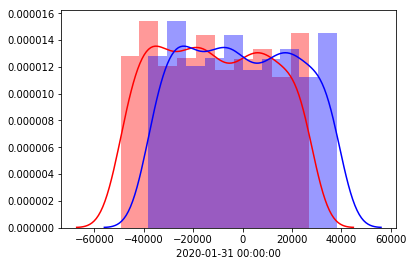

In [1512]:
sns.distplot(simulationhedge.loc[pd.to_datetime('2020-01-31')],color='red')
sns.distplot(simulationunhedge.loc[pd.to_datetime('2020-01-31')],color='blue')

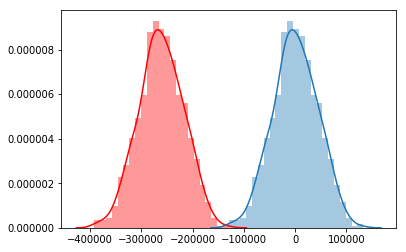

In [1513]:
sns.distplot(density_hedge,color='red')
sns.distplot(density_unhedge)


In [1514]:
comparaison=pd.DataFrame(index=['Mean Hedge','Mean Unhedge','95% Hedge','95% Unhedged','5% Hedge','5% Unhedged'])

In [1515]:
for date in simulationhedge.index:
    MH=simulationhedge.loc[date].mean()
    MU=simulationunhedge.loc[date].mean()
    QH=np.percentile(simulationhedge.loc[date],95,interpolation='linear')
    QU=np.percentile(simulationunhedge.loc[date],95,interpolation='linear')
    QH5=np.percentile(simulationhedge.loc[date],5,interpolation='linear')
    QU5=np.percentile(simulationunhedge.loc[date],5,interpolation='linear')
    comparaison[date]=[MH,MU,QH,QU,QH5,QU5]

In [1516]:
print(comparaison.loc['Mean Hedge'].mean())
print(comparaison.loc['Mean Unhedge'].mean())

-4352.429089966138
12.964937637077863


In [1517]:
comparaison.keys()

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
      

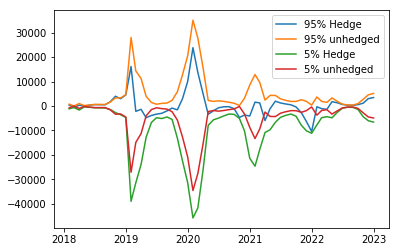

In [1518]:
#plt.plot(comparaison.keys(),comparaison.loc['Mean Hedge'].values,label='Mean Hedge')
#plt.plot(comparaison.keys(),comparaison.loc['Mean Unhedge'].values,label='Mean UnHedge')
plt.plot(comparaison.keys(),comparaison.loc['95% Hedge'].values,label='95% Hedge')
plt.plot(comparaison.keys(),comparaison.loc['95% Unhedged'].values,label='95% unhedged')
plt.plot(comparaison.keys(),comparaison.loc['5% Hedge'].values,label='5% Hedge')
plt.plot(comparaison.keys(),comparaison.loc['5% Unhedged'].values,label='5% unhedged')
plt.legend()


## Case Volume not correlated with price

In [1498]:
PL['Real Conso']=np.random.normal(1,0.1,len(synthese))*PL['Expected Conso']
PL['Open position']=(PL['Expected Conso']-PL['Real Conso'])
PL['PL Hedge']=PL['Real Conso']*PL['VWAP'] +synthese['Valueofhedge'] - PL['Expected Conso']*PL['VWAP'] -(PL['Real Conso']-PL['Hedge Volume'])*PL['Spot Price']
PL['PL Unhedged']=PL['Real Conso']*PL['VWAP'] - PL['Expected Conso']*PL['VWAP'] +(PL['Expected Conso']-PL['Real Conso'])*PL['Spot Price']

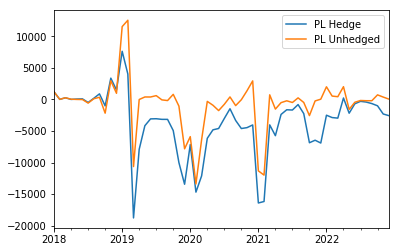

In [1499]:
#PL['PL Hedge'].plot()
PL['PL Hedge'].plot()
PL['PL Unhedged'].plot()
plt.legend()

In [1500]:
PL.describe()

,VWAP,Spot Price,Expected Conso,Hedge Volume,Real Conso,Value Hedge,Open position Hedge,Open position Unhedged,PL Hedge,PL Unhedged,Open position
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,19.116814,19.987668,17273.111403,17864.283658,17290.078573,-16032.817935,361.718663,-229.453593,-3564.492905,-675.858418,-16.967170
std,0.793508,2.535339,14941.285187,15674.960717,15635.099327,22639.077204,1436.797828,1723.023903,4972.567200,4164.461741,2165.489923
min,17.626902,16.314581,891.000000,970.069443,876.987123,-91205.566488,-4407.957265,-5994.063947,-18786.769884,-13397.254107,-8589.843513
25%,18.619696,18.092433,4025.201856,4575.592377,3870.047606,-25063.932317,-190.477437,-806.089331,-4845.093462,-805.059599,-249.337792
50%,19.282759,19.660271,11479.756784,11616.668275,11607.281523,-4475.573962,280.951119,-47.647898,-2715.465487,-24.434139,103.423475
75%,19.497510,21.649265,30062.773067,31463.173270,28375.086843,-1756.239602,999.731719,549.103364,-462.257329,412.374147,738.852556
max,20.475836,27.579998,52672.281273,55839.053242,54295.104747,3422.886072,4428.400235,4428.400235,7642.444561,12567.698379,5184.319475
